In [1]:
import torch
import torchvision.models as models
import torch.nn.functional as F
import numpy as np
import os
import albumentations
from albumentations.pytorch.transforms import ToTensor
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

In [2]:
EPOCH = 500
#set to 1000 for composition7, 10000 for starry night
alpha = 1000 
img_size = 512
device = 'cuda'
content_reference = 'tubingen.jpg'
style_reference = 'starry.jpg'

In [3]:
C_orig = plt.imread(content_reference)
S_orig = plt.imread(style_reference)

In [4]:
transform = albumentations.Compose([
    albumentations.Resize(img_size,img_size,always_apply=True),
    albumentations.Normalize(always_apply=True),
    ToTensor()
])

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [5]:
def gram_matrix(filter):
    nc, h, w = filter.shape
    g = filter.view(nc, h*w)
    gram = torch.mm(g, g.t())
    return gram

In [6]:
def save_image(G, epoch):
    image = unorm(G.cpu().detach().squeeze())
    image = image.numpy()
    image = np.transpose(image, (1,2,0))
    image = np.clip(image, 0, 1)
    plt.imsave(f'generated/generated_{epoch}.jpg', image)
    pass

In [7]:
C = transform(image=C_orig)['image'].to(device)
S = transform(image=S_orig)['image'].to(device)
model = models.vgg16(pretrained=True).to(device)
for param in model.parameters():
    param.requires_grad = False
G = torch.tensor(C.cpu().numpy(), requires_grad=True, device=device)
optimizer = torch.optim.LBFGS([G])

In [8]:
losses = {'content':[], 'style': [], 'total':[]}

In [9]:
pbar = tqdm(total=EPOCH)

epoch=0
while epoch<=EPOCH:
    def closure():
        global epoch
        #initialize
        optimizer.zero_grad()
        content_data = torch.stack([C,G])
        style_data = torch.stack([S,G])

        #compute content loss
        content = model.features[:20](content_data)
        loss_content = F.mse_loss(content[0],content[1])
        
        #compute style loss
        layers = []
        layers.append(model.features[0](style_data))
        layers.append(model.features[1:8](layers[-1]))
        layers.append(model.features[8:15](layers[-1]))
        layers.append(model.features[15:22](layers[-1]))
        layers.append(model.features[22:29](layers[-1]))

        style_losses = []
        for i in range(len(layers)):
            num_channels = layers[i].shape[1]
            num_pixels = layers[i].shape[2]
            factor = 4*num_channels*num_channels*num_pixels*num_pixels
            style_losses.append(F.mse_loss(gram_matrix(layers[i][0]), gram_matrix(layers[i][1]))/factor)

        loss_style = sum(style_losses)/len(style_losses)

        #total loss
        loss = loss_content + alpha*loss_style

        #backprop
        loss.backward()

        #log metrics
        losses['content'].append(loss_content.item())
        losses['style'].append(alpha*loss_style.item())
        losses['total'].append(loss.item())
        if (epoch+1)%50==0:
            tqdm.write(f'Epoch: {epoch}, Content Loss: {loss_content.item()}, Style Loss: {loss_style.item()}, Loss: {loss.item()}\n')
            save_image(G, epoch)
        pbar.update()
        epoch+=1

        return loss

    optimizer.step(closure)
    
pbar.close()

Epoch: 49, Content Loss: 13.565659523010254, Style Loss: 0.015659719705581665, Loss: 29.225379943847656

Epoch: 99, Content Loss: 8.821735382080078, Style Loss: 0.006001081317663193, Loss: 14.822816848754883

Epoch: 149, Content Loss: 7.289412021636963, Style Loss: 0.0040401616133749485, Loss: 11.329573631286621

Epoch: 199, Content Loss: 6.606027603149414, Style Loss: 0.003402708563953638, Loss: 10.008735656738281

Epoch: 249, Content Loss: 6.192531585693359, Style Loss: 0.0030903194565325975, Loss: 9.282851219177246

Epoch: 299, Content Loss: 5.93419075012207, Style Loss: 0.002904366934671998, Loss: 8.838558197021484

Epoch: 349, Content Loss: 5.762403964996338, Style Loss: 0.0027771457098424435, Loss: 8.539549827575684

Epoch: 399, Content Loss: 5.636573791503906, Style Loss: 0.002693587215617299, Loss: 8.330161094665527

Epoch: 449, Content Loss: 5.542675971984863, Style Loss: 0.0026293888222426176, Loss: 8.172064781188965

Epoch: 499, Content Loss: 5.471524715423584, Style Loss: 0

(0.0, 100.0)

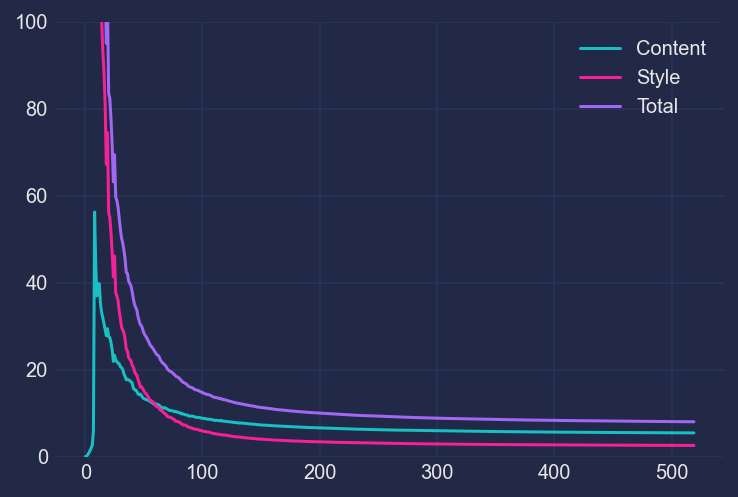

In [10]:
sns.lineplot(x=list(range(len(losses['content']))), y=losses['content'])
sns.lineplot(x=list(range(len(losses['style']))), y=losses['style'])
sns.lineplot(x=list(range(len(losses['total']))), y=losses['total'])
plt.legend(['Content','Style','Total'])
plt.ylim(0,100)